# MC-BNB / MC-Cosmic comparison to data
## A closure study - can we extract $m_A=0.99$ GeV from the distirbution of the truth-$Q^2$ using GENIE event weight?

In [2]:
import sys; sys.path.insert(0, '../../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [3]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/MCCosmic/'

In [4]:
versions['overlay date'] = '2018_07_17'
versions['Overlay'] = 'prodgenie_bnb_nu_cosmic_uboone_mcc8.7_reco2_dev'

In [5]:
OverlayPairsFV, OverlaySamples = load_MCbnbDATAcosmicSamples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')

77177 pairs from MC-BNB + cosmic DATA overlay
53305 pairs in FV
10785 are 1mu-1p, 20.2%
8496 are other pairs, 15.9%
34064 are cosmic, 63.9%
--------------------------------------------------------------
5310 are CC 1p 0pi, 10.0%


## 2. apply the event-selection cuts

In [6]:
cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order)
print 'applied cuts to overlay'

applied cuts to overlay


In [7]:
selected_overlay=dict()
for pair_type in pair_types:
    selected_overlay[pair_type] = reducedOverlay['Pt & delta phi'][pair_type]
selected_overlay_concat = pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])    
print len(pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])),'events in the overlay'
selected_CC1p0pi = selected_overlay['CC 1p 0pi']
print len(selected_CC1p0pi),'selected CC 1p 0pi pairs in overlay'

2295 events in the overlay
1757 selected CC 1p 0pi pairs in overlay


## 3. compare the shapes and rates after the event-selection cuts

In [8]:
mA_array = [0.40,0.70,0.80,0.95,0.99,1.00,1.10,1.15,1.35,1.71]
mA_names = ['040','070','080','095','099','100','110','115','135','171']

In [9]:
def sample_quasidata_from_overlay(selected_overlay=None,Nrand=1):
    quasidataSamples = dict()
    for pair_type in pair_types:#{
        nrand_pair_type = int(len(selected_overlay[pair_type])*Nrand/len(selected_overlay_concat))
        quasidataSamples[pair_type] = selected_overlay[pair_type].sample(n=nrand_pair_type)
    return pd.concat([quasidataSamples['1mu-1p'],quasidataSamples['cosmic'],quasidataSamples['other pairs']])

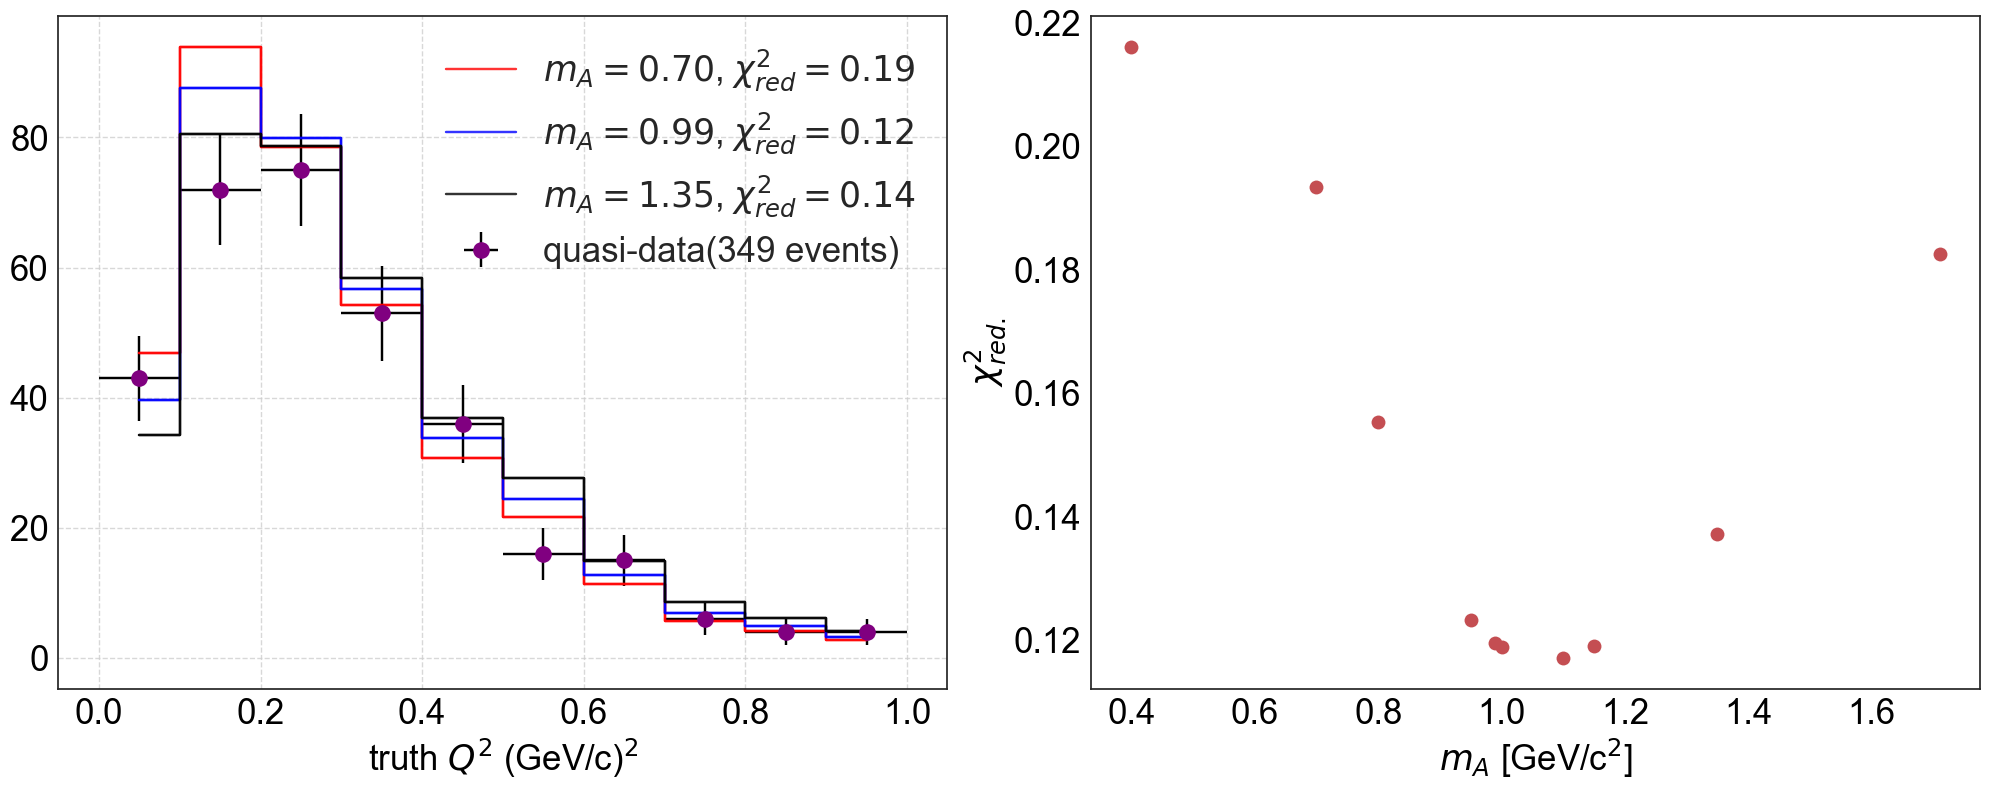

In [26]:
Nrand = 350
bins = linspace(0,1,11); mid = 0.5*(bins[1:]+bins[:-1])
chi2_xrange = (0.,1)

fig=plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)

quasidata = sample_quasidata_from_overlay(selected_overlay=selected_overlay,Nrand=Nrand+1)

mc = selected_overlay
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=quasidata,color='purple',var='truth_Q2',label='quasi-data', bins=bins, markersize=12, ax=ax, do_return_h=True)

for mA,name,color in zip([0.7,0.99,1.35],['070','099','135'],['red','blue','black']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc, norm=Nrand
                                                   , ax=ax
                                                   , var='truth_Q2'
                                                   , weights_var='evwgh_mA'+name+'_Genie', bins=bins
                                                   , do_individual_histograms=False, stackColor=color
                                                   , stackLabel=None)
    if chi2_xrange is not None:
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
        h_overlay,_=plot_stacked_MCsamples( OverlaySamples=mc, norm=Nrand
                                           , ax=ax
                                           , var='truth_Q2'
                                           , weights_var='evwgh_mA'+name+'_Genie'
                                           , bins=bins, do_individual_histograms=False, stackColor=color
                                           ,stackLabel='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.2f$'%(chi2/ndf))
set_axes(ax,r'truth $Q^2$ (GeV/c)$^2$','',do_add_legend=True,legend_loc='upper right')


ax = fig.add_subplot(1,2,2)
chi2_red = []
for mA,name in zip(mA_array,mA_names):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc, norm=Nrand, do_draw=False, var='truth_Q2', weights_var='evwgh_mA'+name+'_Genie', bins=bins)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
    chi2_red.append(chi2/ndf)
plt.errorbar(mA_array,chi2_red,fmt='ro',markersize=10)
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$\chi^2_{red.}$')
plt.tight_layout()

In [30]:
Nrand = 350
Nexpriments = 3
results_experiments = pd.DataFrame(columns=mA_array)
results_mA_min = []
mc = selected_overlay
h_overlay,h_overlay_err=dict(),dict()
for mA,name in zip(mA_array,mA_names):
    h_overlay[mA],h_overlay_err[mA]=plot_stacked_MCsamples( OverlaySamples=mc, norm=Nrand, do_draw=False, var='truth_Q2', weights_var='evwgh_mA'+name+'_Genie', bins=bins)

for i in range(Nexpriments):    
    if Nexpriments>10 and i%(Nexpriments/10)==0: print 'running quasiexperiment',i
    quasidata = sample_quasidata_from_overlay(selected_overlay=selected_overlay,Nrand=Nrand+1)
    h_quasidata,h_quasidata_err=plot_OnBeam(OnBeamSample=quasidata,color='purple',var='truth_Q2',label='quasi-data', bins=bins, markersize=12, ax=ax, do_return_h=True,do_draw=False)    
    res = dict()
    mA_min = 0
    for mA,name in zip(mA_array,mA_names):
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                             , h1=h_quasidata , h1err=h_quasidata_err
                                             , h2=h_overlay[mA]   ,  h2err=h_overlay_err[mA]
                                             , debug=0)
        res[mA] = (chi2/ndf)
        if res[mA]<res[mA_min]: mA_min=mA
    results_experiments.loc[i] = res
    print 'res:',res
    print 'np.argmin(res):',np.argmin(res)
    results_mA_min = mA
print 'done running %d quasiexperiments.'%Nexpriments

res: {1.15: 0.13088697018901663, 1.0: 0.10996612891321228, 0.4: 0.12879701172541985, 0.8: 0.106053935344047, 1.35: 0.16714985104613822, 0.99: 0.10898633200044107, 1.1: 0.12284611781054627, 1.71: 0.23110604550660474, 0.95: 0.10579999796574381, 0.7: 0.11886290916443916}
np.argmin(res): 0
res: {1.15: 0.089203676239166307, 1.0: 0.094244125452434629, 0.4: 0.22027722253295107, 0.8: 0.14260053207387091, 1.35: 0.10266678932439355, 0.99: 0.095357310313530355, 1.1: 0.088799332457349028, 1.71: 0.14275878868973249, 0.95: 0.10096441137477684, 0.7: 0.19080750925533896}
np.argmin(res): 0
res: {1.15: 0.074684912201615133, 1.0: 0.074603383825509323, 0.4: 0.20218731515094635, 0.8: 0.12008456989931661, 1.35: 0.095085198935378756, 0.99: 0.075422500803538198, 1.1: 0.072479730629582614, 1.71: 0.14501286047848952, 0.95: 0.079974062783123259, 0.7: 0.17052003452042958}
np.argmin(res): 0
done running 3 quasiexperiments.


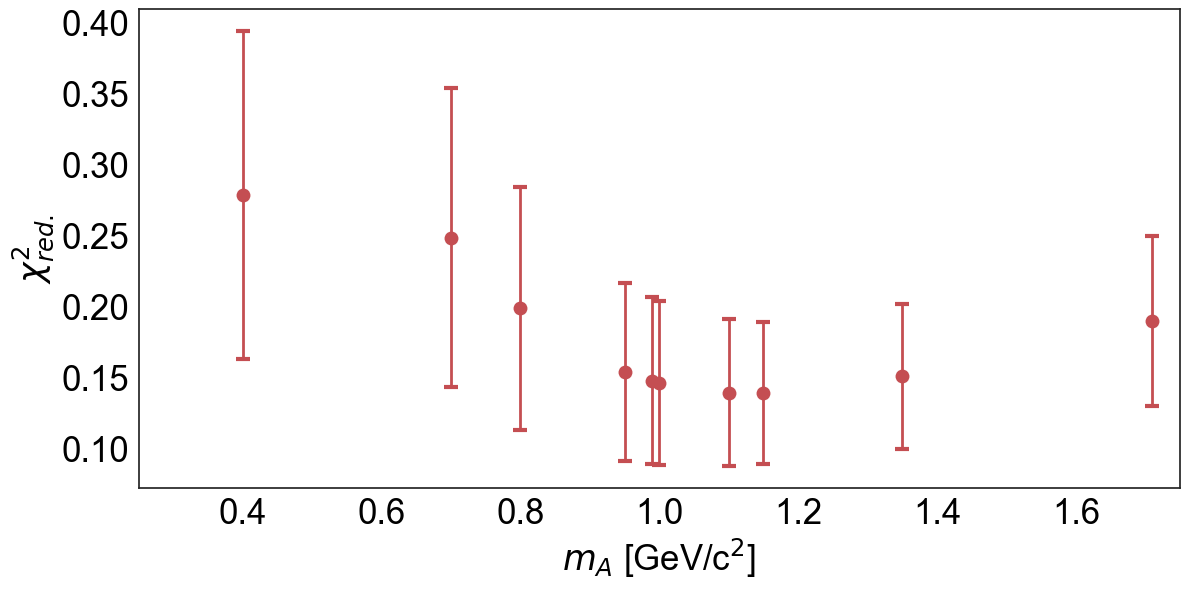

In [18]:
fig=plt.figure(figsize=(12,6));
ax=fig.add_subplot(1,1,1)
chi2_mean,chi2_std = [],[]
for mA in mA_array:
    chi2_mean.append(np.mean(results_experiments[mA]))
    chi2_std.append(np.std(results_experiments[mA]))
plt.errorbar( x=mA_array,y=chi2_mean,yerr=chi2_std , fmt='ro',markersize=10,linewidth=2,capsize=5,capthick=3)
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$\chi^2_{red.}$',xlim=(0.25,1.75))
plt.tight_layout()

# compare using KS test

In [14]:
from scipy import stats
from scipy.stats import distributions

In [15]:
#  -- - -- -- - -- - - - - - - - - ---- -- ---- 
# July-05,2018
def weighted_repeat(array, weights, epsilon=0.01,debug=0):
    '''
    written for KS test using standard (non-weighted) arrays
    
    input:
    array + weights
    
    return:
    repeated array representing the weighted array
    
    '''
    w_min = np.max([epsilon ,np.min(weights)])
    weights_as_repetition_numbers = np.array([np.max([1,int(round(w/w_min))]) for w in weights])
    if debug:
        print 'array:',array
        print 'weights:',weights
        print 'w_min:',w_min
        print 'weights_as_repetition_numbers:',weights_as_repetition_numbers
    repeated_array = np.repeat(array, weights_as_repetition_numbers, axis=0)
    if debug:
        print 'repeated_array:',repeated_array
    return repeated_array
#  -- - -- -- - -- - - - - - - - - ---- -- ---- 

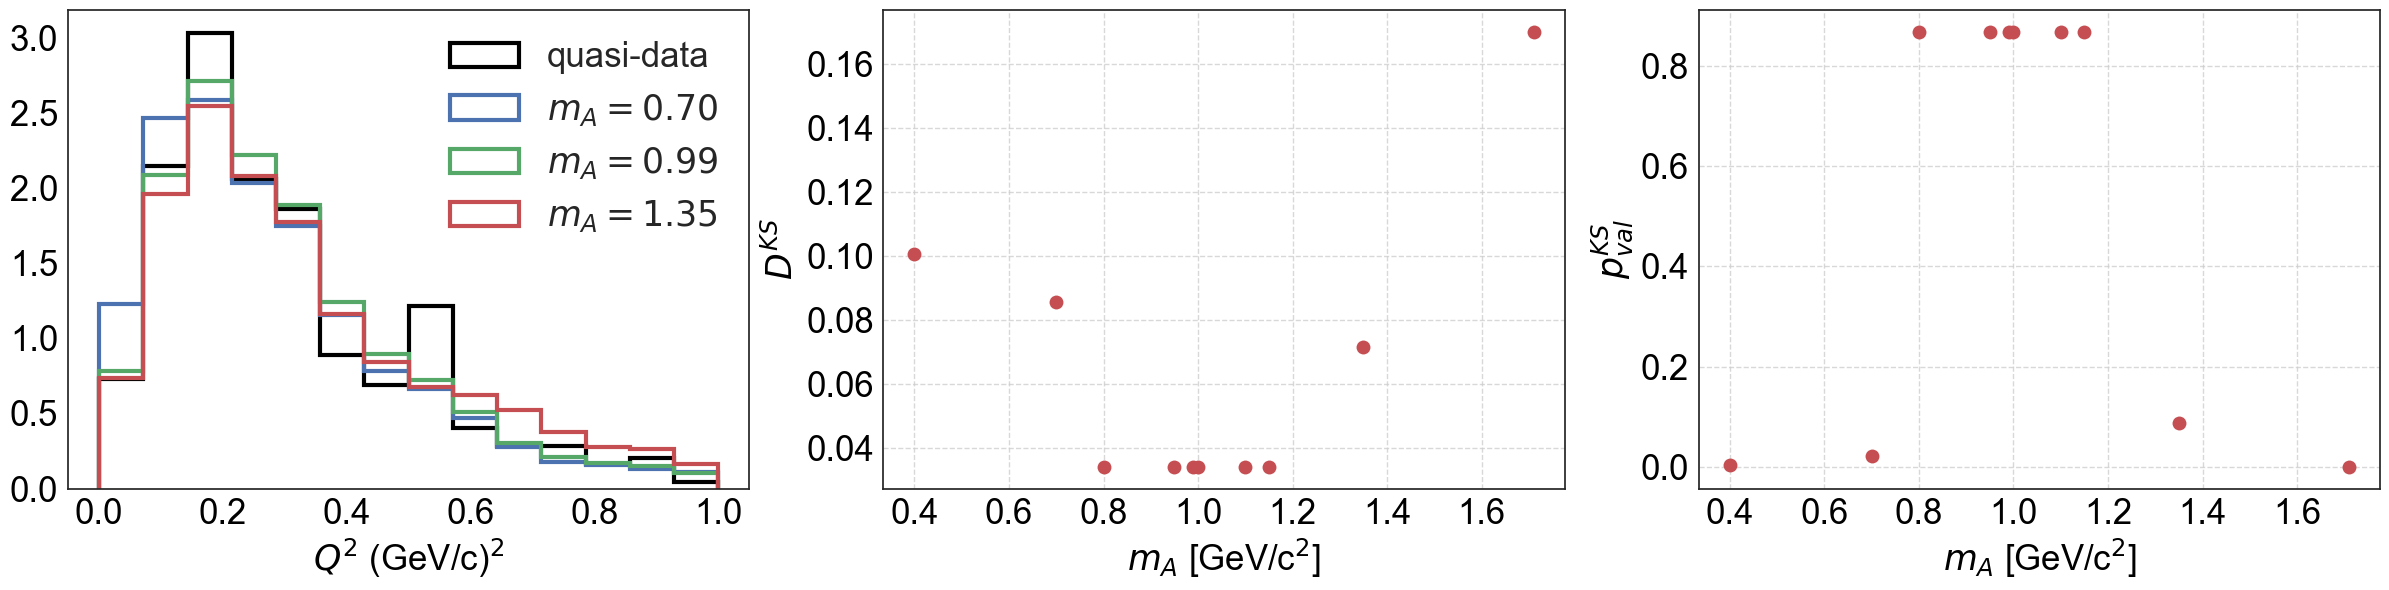

In [16]:
Nrand = 350 # len(selected_overlay_concat)-2

mc = selected_overlay_concat
mc_array = np.array(mc['closest_genie_Q2'])

quasidata = sample_quasidata_from_overlay(selected_overlay=selected_overlay,Nrand=Nrand+1)
quasidata_array = np.array(quasidata['closest_genie_Q2'])


bins=linspace(0,1,15)
fig=plt.figure(figsize=(24,6));
ax = fig.add_subplot(1,3,1)
plt.hist(quasidata_array,bins=bins,normed=1,label='quasi-data',histtype='step',linewidth=3,color='black')


Pval_df = pd.DataFrame(columns={'mA','KS_D','KS_Pval','my_Pval'})
for mA,name in zip(mA_array,mA_names):
    mc_weights = np.array(mc['evwgh_mA'+name+'_Genie'])
    mc_repeated_array = weighted_repeat(mc_array, mc_weights,epsilon=0.1,debug=0 if mA!=0.7 else 0) 
    
    KS_D,KS_Pval = stats.ks_2samp(mc_repeated_array, quasidata_array)
    # we do not take standard KS_Pval,
    # as we want to compute the Pval for size n,
    # n-being the real number of events, not the repeated-array size...
    n1 = len(quasidata_array);n2 = len(mc_array)
    en = np.sqrt(n1 * n2 / float(n1 + n2))
    my_Pval = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * KS_D)
    Pval_df = Pval_df.append(pd.DataFrame({'mA':mA,'KS_D':KS_D,'KS_Pval':KS_Pval,'my_Pval':my_Pval},index=[mA]))    
    
    if mA in [0.7,0.99,1.35]:
        plt.hist(mc_repeated_array,bins=bins,normed=1,label='$m_A=%.2f$'%mA,histtype='step',linewidth=3)
        
set_axes(ax,r'$Q^2$ (GeV/c)$^2$','',do_add_legend=True)

ax = fig.add_subplot(1,3,2)
x,y = Pval_df['mA'] , Pval_df['KS_D']
plt.plot( x,y , 'ro',markersize=10,linewidth=2)
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$D^{KS}$',do_add_grid=True)


ax = fig.add_subplot(1,3,3)
x,y = Pval_df['mA'] , Pval_df['my_Pval']
plt.plot( x,y , 'ro',markersize=10,linewidth=2)
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$p_{val}^{KS}$',do_add_grid=True)
plt.tight_layout()

# compare using Likelihood
The way we do it is by separating Likelihood to the number of events $\times$ the likelihood to the shape
$$ \hat l(data \; | \;m_A) = l(N_{data} \; | \;m_A-integral) \times l(data \; | \;m_A-shape)
$$
where 
$$
l(N_{data} \; | \;m_A-integral) = P_{Poisson} (N_{data} \; | \; \int dQ^2 (m_A))
$$

assuming a Poisson distribution for the number of events with $m_A$ as input $I_{m_A} = \int dQ^2 (m_A)$, 

$$
    l(N_{data} \; | \;m_A-integral) 
    = \frac{e^{-{I_{m_A}}}}{(N_{data})!} (I_{m_A})^{N_{data}} 
    \sim
    \frac{e^{N_{data}-{I_{m_A}}}}{ \sqrt{2\pi N_{data}} } \left(\frac{I_{m_A}}{N_{data}}\right)^{N_{data}}
$$


In [48]:
from scipy.stats import distributions

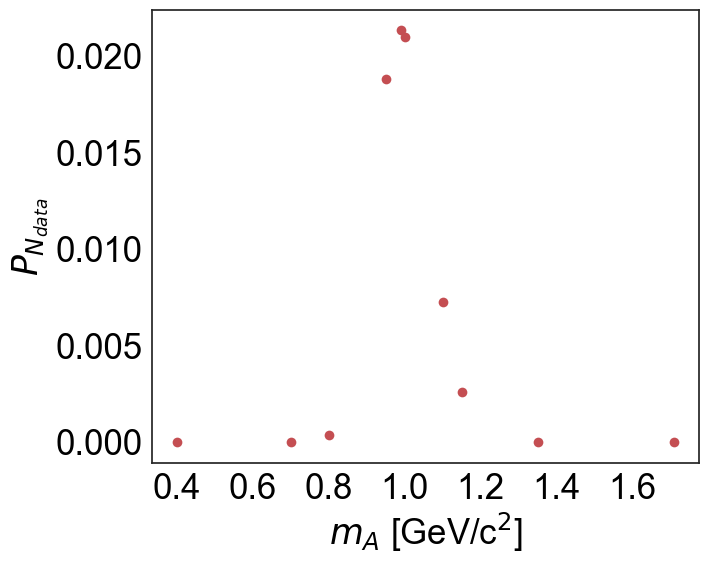

In [78]:
Nrand = 350
quasidata_time = float(Nrand) / len(selected_overlay_concat)

quasidata = sample_quasidata_from_overlay(selected_overlay=selected_overlay,Nrand=Nrand+1)
quasidata_array = np.array(quasidata['closest_genie_Q2'])
N_data = float(len(quasidata_array))

mc = selected_overlay_concat
mc_array = np.array(mc['closest_genie_Q2'])
I_mc,I_mc_normalized,P_poisson = dict(),dict(),dict()
l = []
for mA,name in zip(mA_array,mA_names):
    mc_weights = np.array(mc['evwgh_mA'+name+'_Genie'])    
    I_mc[mA] = np.sum(mc_weights)
    I_mc_normalized[mA] = I_mc[mA]*quasidata_time    
    P_poisson[mA] = distributions.poisson.pmf(N_data , I_mc_normalized[mA])    
    l.append(P_poisson[mA])

# print 'I_mc_normalized:',I_mc_normalized
# print 'N_data:',N_data

fig=plt.figure(figsize=(24,6));
ax = fig.add_subplot(1,3,1)
plt.errorbar(x=mA_array,y=l,fmt='ro',color='black')
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$P_{N_{data}}$')

# ax = fig.add_subplot(1,3,3)
# x,y = Pval_df['mA'] , Pval_df['my_Pval']
# plt.plot( x,y , 'ro',markersize=10,linewidth=2)
# set_axes(ax,r'$m_A$ [GeV/c$^2$]','$p_{val}^{KS}$',do_add_grid=True)
# plt.tight_layout()

In [76]:
distributions.poisson.pmf(2,2)

0.2706705664732254